# Starbucks Capstone Challenge

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [32]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 177 kB/s  eta 0:00:01     |████████████▌                   | 18.3 MB 13.6 MB/s eta 0:00:03


#### Import libraries

In [63]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

import os
import io

from sklearn import preprocessing

!pip install pandas-profiling
from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize

# Libreria personalizada
import helpers

# Visualización de missing values
import missingno as msno


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn import metrics


!pip install klib
import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import warnings
warnings.filterwarnings('ignore')

print("Successful import!!!")

Successful import!!!


In [2]:
# sagemaker libraries
import boto3
import sagemaker

##### Read dataset

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [16]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [17]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [18]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### EDA (Exploratory Data Analysis)

In [19]:
print(f"Dataset portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns")
print(f"Dataset profile have {profile.shape[0]} rows and {profile.shape[1]} columns")
print(f"Dataset transcript have {transcript.shape[0]} rows and {transcript.shape[1]} columns")

Dataset portfolio have 10 rows and 6 columns
Dataset profile have 17000 rows and 5 columns
Dataset transcript have 306534 rows and 4 columns


Once the amount of data is taken into account, we will check how many missing values there are in each dataset.

##### Detect missing values for each dataset

<br>

##### Portfolio

In [20]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

As can be seen, this dataset does not have any null value.

##### Profile

In [21]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
# Ratio of missing values to the actual dataset
print(f"There is a {round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)}% of missing values in the dataset Profile ")

There is a 12.79% of missing values in the dataset Profile 


##### Transcript

In [15]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Like the ``portfolio`` dataset, ``transcript`` has no missing values. 

<br> 

Let's explore each of the different events that can be seen within the transcript dataset.

In [16]:
transcript.groupby('event').count()

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


The following image shows the funnel of sales conversions of the marketing campaign. In the upper part are the ``offers received`` with a total of **76277**, in the middle part the ``offers viewed`` with **57725**, representing ``76%`` of the total ``offers received``.

<br>

Finally, the conversion of ``offers completed``  was **33579** which is ``44%`` of the offers sent.

<br> 

<img src="images/funnel.jpg"    
     style="max-width: 50%">

Now the event column of the ``transcript`` table will be normalized to know what type of event the ``offer_id`` refers to and thus interpret the data in depth. For this purpose, two functions were designed to meet this objective.


In [14]:
# Dataset del evento amount
transaction = helpers.merge_dataset(transcript, "value", "amount")
transaction.head(5)

,index,person,event,time,amount
0,12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
2,12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
4,12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [83]:
# Dataset del evento ofertas recibidas y vistas
offers = helpers.merge_dataset(transcript, "value", "offer id")
offers.head(5)

,index,person,event,time,offer id
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
# Event dataset of completed offers
offer_completed = helpers.merge_dataset(transcript, "value", "offer_id")
offer_completed.head(5)

,index,person,event,time,offer_id
0,12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5
1,12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4
2,12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd
4,12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Extracting important values from profile

In [22]:
import datetime

cleaned_profile = profile.copy()

#Dropping rows with null information
cleaned_profile.dropna(inplace = True)

#Changing 'id' column name to more appropriate 'customer_id' name
cleaned_profile.rename(columns = {'id': 'user_id'}, inplace = True)

#Changing 'became_member_on' column to a date type
cleaned_profile['became_member_on'] = cleaned_profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())

#Calculating number of days as a member 
end = pd.Timestamp('2021-06-01')
end = pd.to_datetime(end)
cleaned_profile['days_as_member'] = np.abs((pd.to_datetime(cleaned_profile['became_member_on']) - end).dt.days)

#Creating 'age_range' column based on 'age'
age_range_list = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
cleaned_profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_list, right = False)

cleaned_profile

,gender,age,user_id,became_member_on,income,days_as_member,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1417,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1484,70-79
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1132,60-69
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1208,60-69
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1298,50-59
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1093,40-49
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1054,60-69
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1587,40-49
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1912,80+


#### Extracting important values from transcript

In [23]:
cleaned_transcript = transcript.copy()

#Changing the 'person' column name to 'user_id'
cleaned_transcript.rename(columns = {'person': 'user_id'}, inplace = True)

# One hot encode event values
event_dummies = pd.get_dummies(cleaned_transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
cleaned_transcript = pd.concat([cleaned_transcript, event_dummies], axis = 1)

# Change 'time' column to 'days' along with the appropriate values
cleaned_transcript['days'] = cleaned_transcript['time'] / 24
cleaned_transcript.drop(columns = ['time'], inplace = True)

# separate value columns into different columns
cleaned_transcript['offer-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.keys())[0])
cleaned_transcript['id-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.values())[0])

# changing all offer ids to a unified name: offer_id
trans_offer_dict = {'offer id': 'offer_id'}
cleaned_transcript['offer-or-amount'].replace({'offer id':'offer_id'}, inplace = True)

# Creating the offer DataFrame for transcript dataset
transcript_dataset_offer = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'offer_id']
transcript_dataset_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_dataset_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

# Creating the amount DataFrame for transcript dataset
transcript_dataset_amount = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'amount']
transcript_dataset_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_dataset_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)
transcript_dataset_amount

,user_id,transaction,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,1,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,0.00,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,1,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,1,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,1,29.75,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,1,29.75,3.53


#### Extracting important values from portfolio

In [24]:
cleaned_portfolio = portfolio.copy()

# creating a unified identifier for the ids of offers: offer_id
cleaned_portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

# One hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(cleaned_portfolio['offer_type'], prefix = 'offer')
cleaned_portfolio = pd.concat([cleaned_portfolio, offer_dummies], axis = 1)
cleaned_portfolio.drop(columns=['offer_type'], inplace=True)

#Separating and one hot encoding the channels field
channels_one_hot = preprocessing.MultiLabelBinarizer()
sep_channels = channels_one_hot.fit_transform(cleaned_portfolio['channels'])
channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
cleaned_portfolio = pd.concat([cleaned_portfolio, channels_df], axis = 1)
cleaned_portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
cleaned_portfolio.drop(columns=['channels'], inplace=True)
cleaned_portfolio 

,reward,difficulty,duration,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


#### Merging

In [44]:
def unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    entries = []
    
    for user_id in user_ids:
        # Extracting user attributes
        user = cleaned_profile[cleaned_profile['user_id'] == user_id]
        age = user['age'].values[0]
        gender = user['gender'].values[0]
        income = user['income'].values[0]
        age_range = user['age_range'].values[0]

        # New features to be added
        total_viewed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_viewed'].sum()
        total_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_received'].sum()
        total_completed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_completed'].sum()
        total_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].sum()
        avg_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].mean()
        num_transactions = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['transaction'].sum()

        # percentages of completed and viewed
        percent_viewed = round(total_viewed / total_received * 100, 2)
        percent_completed = round(total_completed / total_received * 100, 2)

        # Completed offers
        offer_completed_df = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        # Offers received
        offers_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_id'].values.tolist()
        bogos = portfolio[portfolio['offer_type'] == 'bogo']['id'].to_list()
        discounts = portfolio[portfolio['offer_type'] == 'discount']['id'].to_list()
        
        #Initializing variables we will use later on down
        discounts_received = 0
        bogos_received = 0

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for offer in offers_received:
            #Iterating through all the bogo offers
            if offer in bogos:
                bogos_received += 1
            #Iterating through all the discount offers
            elif offer in discounts:
                discounts_received += 1

        #Determining the percentage of bogo & discount offers actually completed versus how many of each were offered
        if bogos_received > 0:
            bogo_percent_completed = round((completed_bogo / bogos_received) * 100 , 2)
        else:
            bogo_perecent_completed = 0.0

        if discounts_received > 0:
            discount_percent_completed = round((completed_discount / discounts_received) * 100, 2)
        else:
            discount_percent_completed = 0.0

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'user_id': user_id,
                        'age': age,
                        'gender': gender,
                        'income': income,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'bogos_received': bogos_received,
                        'completed_bogo': completed_bogo,
                        'discounts_received': discounts_received,
                        'completed_discount': completed_discount,
                        'discount_percent_completed': discount_percent_completed,
                        'bogo_percent_completed': bogo_percent_completed,
                        'percent_viewed': percent_viewed,
                        'percent_completed': percent_completed}

        entries.append(person_entry)
    
    #Building our final DataFrame from the entries list
    final_dataset = pd.DataFrame(entries)
    
    #Creating 'age_range' column based on 'age'
    age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
    age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
    final_dataset['age_range'] = pd.cut(final_dataset['age'], bins = age_range_bins, labels = age_range_labels, right = False)
    final_dataset.drop('age', axis= 1, inplace=True)

    #Creating 'num_transactions_range' column based on 'num_transactions'
    num_transactions_range_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30+']
    num_transactions_range_bins = [0, 5, 10, 15, 20, 25, 30, 50]
    final_dataset['num_transactions_range'] = pd.cut(final_dataset['num_transactions'], bins = num_transactions_range_bins, labels = num_transactions_range_labels, right = False)
    final_dataset.drop('num_transactions', axis= 1, inplace=True)

    #Creating 'bogos_received_range' column based on 'bogos_received'
    bogos_received_range_labels = ['0-4', '5-9', '10-14', '15+']
    bogos_received_range_bins = [0, 5, 10, 15, 25]
    final_dataset['bogos_received_range'] = pd.cut(final_dataset['bogos_received'], bins = bogos_received_range_bins, labels = bogos_received_range_labels, right = False)
    final_dataset.drop('bogos_received', axis= 1, inplace=True)

    #Creating 'discounts_received_range' column based on 'discounts_received'
    discounts_received_range_labels = ['0-4', '5-9', '10-14', '15+']
    discounts_received_range_bins = [0, 5, 10, 15, 25]
    final_dataset['discounts_received_range'] = pd.cut(final_dataset['discounts_received'], bins = discounts_received_range_bins, labels = discounts_received_range_labels, right = False)
    final_dataset.drop('discounts_received', axis= 1, inplace=True)

    #Creating 'percent_viewed_range' column based on 'percent_viewed'
    percent_viewed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
    percent_viewed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
    final_dataset['percent_viewed_range'] = pd.cut(final_dataset['percent_viewed'], bins = percent_viewed_range_bins, labels = percent_viewed_range_labels, right = False)
    final_dataset.drop('percent_viewed', axis= 1, inplace=True)

    #Creating 'percent_completed_range' column based on 'percent_completed'
    percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
    percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
    final_dataset['percent_completed_range'] = pd.cut(final_dataset['percent_completed'], bins = percent_completed_range_bins, labels = percent_completed_range_labels, right = False)
    final_dataset.drop('percent_completed', axis= 1, inplace=True)


    final_dataset.to_csv('data/final_dataset.csv')
    
    return final_dataset

#### Calling the function to generate the unified dataset

In [4]:
# Loop through the customer base and collect data from other datasets
#user_ids = cleaned_profile['user_id'].to_list()

#final_dataset = unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount)
final_dataset = pd.read_csv('data/final_dataset.csv')
final_dataset.drop(['Unnamed: 0', 'user_id'], axis=1, inplace=True)
final_dataset.head()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,discount_percent_completed,bogo_percent_completed,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range
0,F,112000.0,1,0,2,77.01,25.670000,1,0,0.00,50.00,50-59,0-4,0-4,0-4,0-9,50-59
1,F,100000.0,3,4,4,159.27,22.752857,3,0,0.00,33.33,70-79,5-9,5-9,0-4,90-100,70-79
2,M,70000.0,2,3,4,57.73,19.243333,1,2,40.00,33.33,60-69,0-4,0-4,5-9,70-79,50-59
3,M,53000.0,5,6,6,36.43,12.143333,2,2,33.33,18.18,60-69,0-4,10-14,5-9,90-100,80-89
4,M,51000.0,1,2,3,15.62,3.905000,0,2,40.00,18.18,50-59,0-4,0-4,5-9,60-69,30-39


In [5]:
# Categorizing completed discounts percents
discount_percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
discount_percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
final_dataset['discount_percent_completed_range'] = pd.cut(final_dataset['discount_percent_completed'], bins = discount_percent_completed_range_bins, labels = discount_percent_completed_range_labels, right = False)
final_dataset.drop('discount_percent_completed', axis= 1, inplace=True)


# Categorizing completed bogos percents
bogo_percent_completed_range_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']
bogo_percent_completed_range_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110]
final_dataset['bogo_percent_completed_range'] = pd.cut(final_dataset['bogo_percent_completed'], bins = bogo_percent_completed_range_bins, labels = bogo_percent_completed_range_labels, right = False)
final_dataset.drop('bogo_percent_completed', axis= 1, inplace=True)

final_dataset.head()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
0,F,112000.0,1,0,2,77.01,25.670000,1,0,50-59,0-4,0-4,0-4,0-9,50-59,0-9,50-59
1,F,100000.0,3,4,4,159.27,22.752857,3,0,70-79,5-9,5-9,0-4,90-100,70-79,0-9,30-39
2,M,70000.0,2,3,4,57.73,19.243333,1,2,60-69,0-4,0-4,5-9,70-79,50-59,40-49,30-39
3,M,53000.0,5,6,6,36.43,12.143333,2,2,60-69,0-4,10-14,5-9,90-100,80-89,30-39,10-19
4,M,51000.0,1,2,3,15.62,3.905000,0,2,50-59,0-4,0-4,5-9,60-69,30-39,40-49,10-19


In [6]:
final_dataset.tail()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
14820,F,54000.0,0,3,3,20.03,2.861429,1,1,40-49,5-9,0-4,0-4,90-100,0-9,50-59,50-59
14821,M,72000.0,1,1,3,25.97,3.710000,1,0,60-69,5-9,0-4,0-4,30-39,30-39,0-9,50-59
14822,M,73000.0,0,1,3,39.74,4.967500,0,1,40-49,5-9,0-4,0-4,30-39,0-9,90-100,50-59
14823,F,50000.0,3,3,3,189.67,13.547857,3,0,80+,10-14,5-9,0-4,90-100,90-100,0-9,30-39
14824,F,82000.0,2,2,4,143.02,23.836667,1,1,60-69,5-9,0-4,0-4,50-59,50-59,30-39,30-39


In [7]:
# Check number rows and columns
final_dataset.shape

(14825, 17)

In [8]:
# Check missing values
final_dataset.isnull().sum()

gender                                0
income                                0
total_completed                       0
total_viewed                          0
total_received                        0
total_spent                           0
avg_spent                           333
completed_bogo                        0
completed_discount                    0
age_range                             0
num_transactions_range                0
bogos_received_range                  0
discounts_received_range              0
percent_viewed_range                  5
percent_completed_range               5
discount_percent_completed_range      0
bogo_percent_completed_range          0
dtype: int64

Now let's look at the missing values graphically. 

In [9]:
#klib.missingval_plot(final_dataset)

A pattern can be observed in the missing values for the **gender** and **income** columns. The procedure to be performed is to remove each of these null values. 

In [10]:
# Delete missing values
final_dataset.dropna(inplace=True)

With the first data cleaning we performed in the previous steps, we will now generate a report to understand the nature of each of the data. 

In [88]:
# Portfolio report
report = ProfileReport(final_dataset, title='Report for final dataset V1.0', dataset={'creator':'Carlos Barros'},
                        html={'style':{'full_width':True}})

report.to_file("final dataset.html")

In [89]:
report

In [11]:
# Change data type float to int 
for y in final_dataset.columns:
    if(final_dataset[y].dtype == np.float64):
        final_dataset[y] = final_dataset[y].astype(int)

final_dataset.dtypes

gender                                object
income                                 int64
total_completed                        int64
total_viewed                           int64
total_received                         int64
total_spent                            int64
avg_spent                              int64
completed_bogo                         int64
completed_discount                     int64
age_range                             object
num_transactions_range                object
bogos_received_range                  object
discounts_received_range              object
percent_viewed_range                  object
percent_completed_range               object
discount_percent_completed_range    category
bogo_percent_completed_range        category
dtype: object

#### Statistics and Visualization

In [12]:
final_dataset.describe()

,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount
count,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000,14487.000000
mean,65219.990336,2.239525,3.363291,4.488162,119.246290,14.754331,1.489749,1.490992
std,21599.018396,1.564413,1.283693,1.070667,130.231559,16.547979,0.865536,0.871907
min,30000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,1.000000,2.000000,4.000000,34.000000,3.000000,1.000000,1.000000
50%,63000.000000,2.000000,3.000000,5.000000,89.000000,14.000000,1.000000,1.000000
75%,79000.000000,3.000000,4.000000,5.000000,162.000000,21.000000,2.000000,2.000000
max,120000.000000,6.000000,6.000000,6.000000,1608.000000,451.000000,4.000000,4.000000


Display the different functions that are in the file helpers. py

In [72]:
!pygmentize helpers.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn import preprocessing


def drop_missing_values(df, column, target_key):
    """
    
    drop_missing_values: Gets the specified event (target) and converts it into a dataframe.
    
    Parameters:
        df: Transcript dataset
        column: The name of the column where the json objects are located.
        target_key: Name of the key to extract the information
        
    Return:
        df: Normalized dataframe with the specified key, as column, and their respective values.
    """
    df = df[column].apply(pd.Series)
    
    df_final = df[[target_key]]
    df_final = df_final.dropna()
    df_final = df_final.reset_index()
    
    return df_final


def merge_dataset(general_dataset, column, target_key):
    """
    merge_dataset: merge transcript

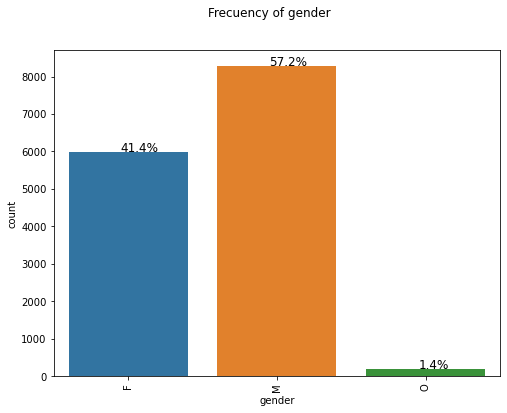

In [37]:
# Display plot for gender column
helpers.plot_category_variable(final_dataset, 'gender')

As can be seen, the majority of the population is **male** with ``57.2%`` followed by **females** with ``41.4%`` and finally **Others** with only ``1.4%`` of our data set.

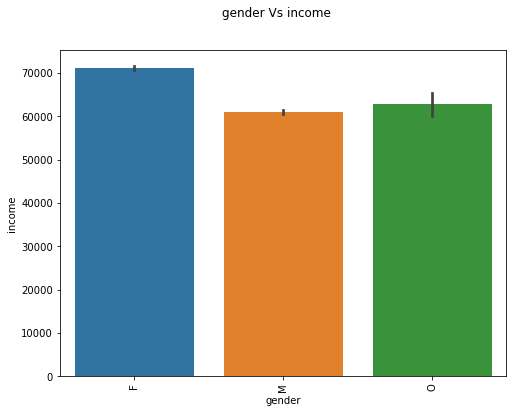

In [38]:
# Display plot Gender VS Income
helpers.plot_cat_num_variable(final_dataset, "gender", "income")

The above shows us a very important detail, which is that despite the fact that **women** represent **41%** of the total population, this gender had a higher income than **men** and **Others**.

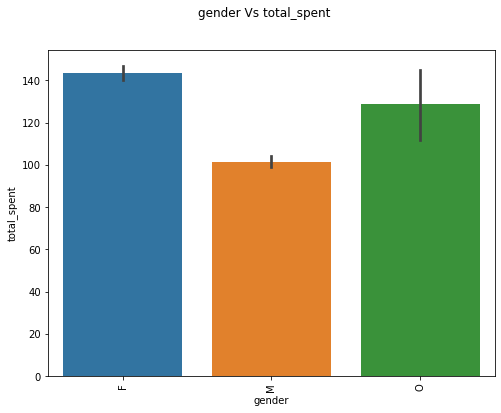

In [39]:
# Display plot Gender VS Total spent
helpers.plot_cat_num_variable(final_dataset, "gender", "total_spent")

Based on the above, **women** are those who spend more on the offers than **men** and **Others**.

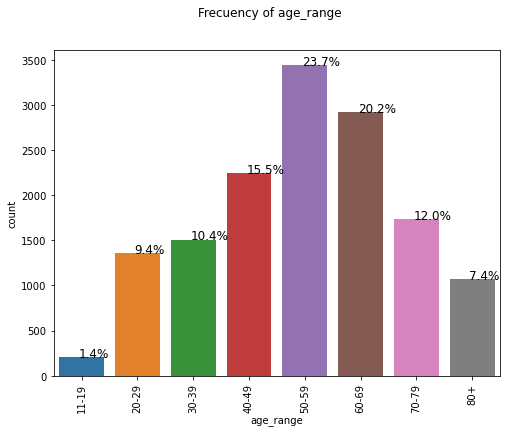

In [40]:
# Display plot for age_range column
helpers.plot_category_variable(final_dataset, 'age_range')

According to the graph, it can be concluded that ``60%`` of the population is in the age range **40 - 69 years old**, belonging to the ``Baby boomers`` generation. On the other hand, ``Millenials`` represent only **20%** of the population.

<br>

The following three graphs are supplemented with **total offers received**, **total offers viewed** and **total offers completed**.

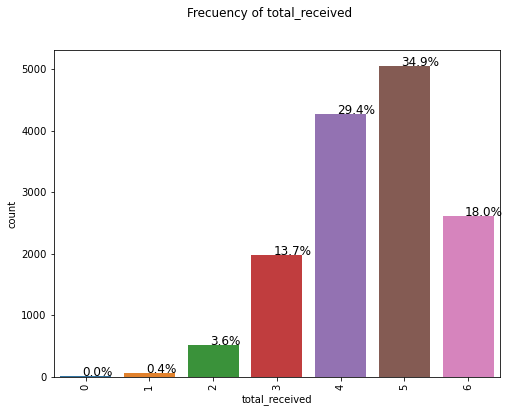

In [40]:
# Display plot for total_received column
helpers.plot_category_variable(final_dataset, 'total_received')

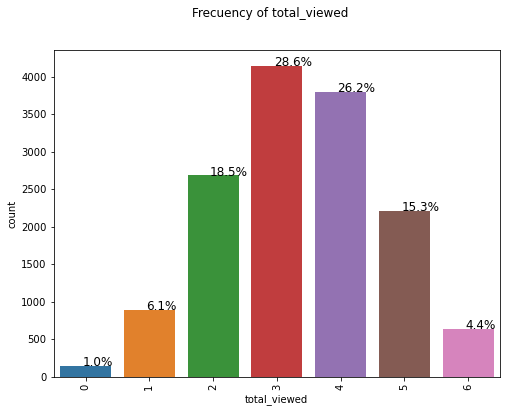

In [39]:
# Display plot for total_viewed column
helpers.plot_category_variable(final_dataset, 'total_viewed')

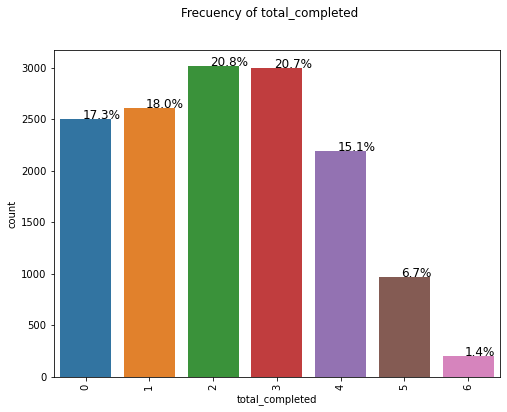

In [42]:
# Display plot for total_completed column
helpers.plot_category_variable(final_dataset, 'total_completed')

In the three previous graphs it can be concluded that of the total population more than **50%** receive between ``4`` and ``5`` offers, of which **28%** manage to see ``3`` and only complete between ``2`` and ``3`` offers. Clearly this represents a *funnel* as specified above. The company needs to send many offers in order to have a conversion rate and thus have a return on investment for its marketing campaign.

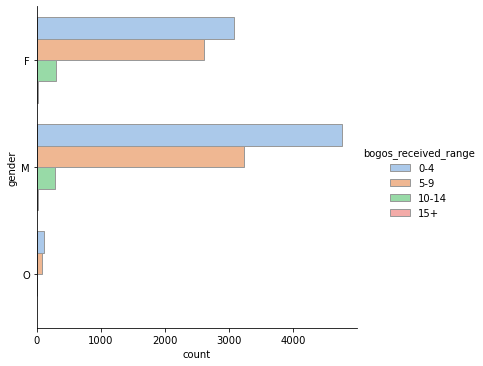

In [64]:
# Display Gender VS Bogos received
sns.catplot(y="gender", hue="bogos_received_range", kind="count",
            palette="pastel", edgecolor=".6",
            data=final_dataset)
plt.show()

In the previous image we can see a pattern of behavior in the sending of **bogo-type offers**, since both ``men`` and ``women`` receive mostly between ``0`` and ``4`` offers of this type. Likewise, the company defined in its marketing campaign to send fewer offers that exceed the aforementioned range.

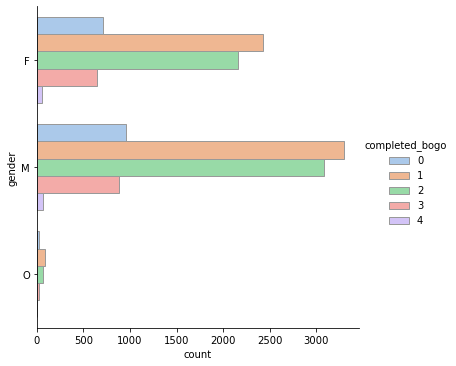

In [68]:
# Display gender VS completed_bogo
sns.catplot(y="gender", hue="completed_bogo", kind="count",
            palette="pastel", edgecolor=".6",
            data=final_dataset)
plt.show()

Meanwhile, men are the gender that completes the most **BOGO** type offers with a range between ``1`` and ``2`` offers, followed by women.

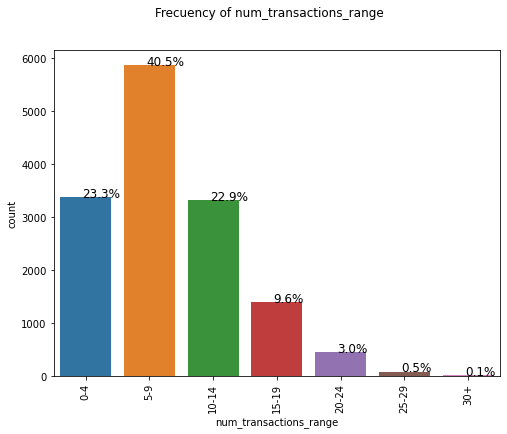

In [69]:
# Display plot for num_transactions_range column
helpers.plot_category_variable(final_dataset, 'num_transactions_range')

In [70]:
final_dataset.columns

Index(['age_range', 'gender', 'income', 'total_completed', 'total_viewed', 'total_received', 'total_spent', 'avg_spent', 'completed_bogo', 'completed_discount', 'num_transactions_range', 'bogos_received_range', 'discounts_received_range'], dtype='object')

In [71]:
final_dataset.dtypes

age_range                   category
gender                        object
income                         int64
total_completed                int64
total_viewed                   int64
total_received                 int64
total_spent                    int64
avg_spent                      int64
completed_bogo                 int64
completed_discount             int64
num_transactions_range      category
bogos_received_range        category
discounts_received_range    category
dtype: object

In [72]:
# Select columns with numeric data types
numeric_columns = final_dataset.select_dtypes([np.int32, np.int64])
numeric_columns = final_dataset[['income', 'avg_spent','total_spent']]

<Figure size 432x288 with 0 Axes>

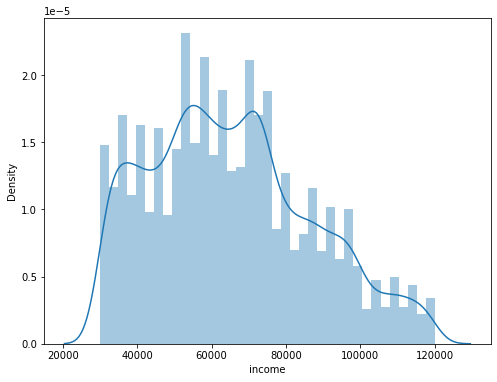

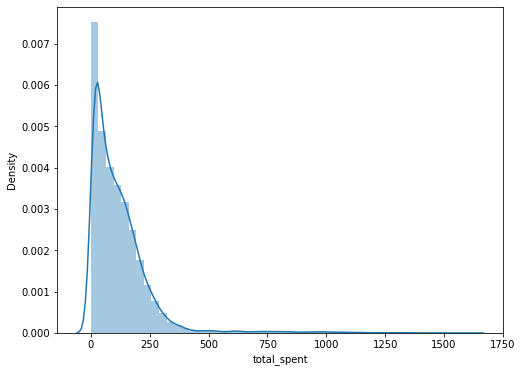

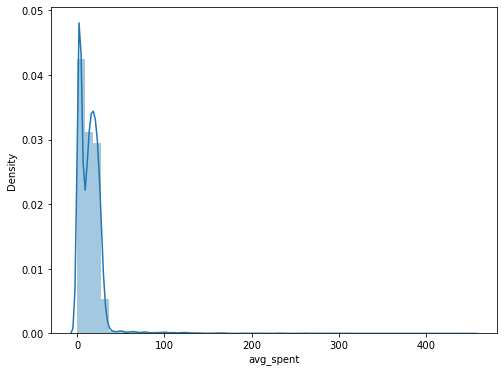

In [73]:
for i, col in enumerate(numeric_columns.columns):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    
    sns.distplot(numeric_columns[col])
    plt.figure(i)

We will now detail the type of asymmetry of each of the graphs shown above.

In [88]:
# Choose numeric datatype
numeric_features = final_dataset.select_dtypes(include=[np.number]).columns
skew_features = final_dataset[numeric_features].skew().sort_values(ascending = False)

# Print skew features
skew_features

avg_spent             7.367948
total_spent           3.590390
income                0.412679
total_completed       0.201160
completed_bogo        0.184910
completed_discount    0.164468
total_viewed         -0.049479
total_received       -0.438556
dtype: float64

It can be observed that the different types of *skewness* among the numerics. Meanwhile, based on our previous graphs, the **avg_spent**, **total_spent** and **income** columns have a ``positively skewed`` distribution with an skewness of greater than **0**.



##### Hopkins Statistics
Tests the spatial randomness of the data and indicates the clustering tendency or how well the data may be clustered
* **0.5 or less** --> data are uniformly distributed
* **0.77 - 0.99** --> high clustering tendency

In [53]:
helpers.hopkins(final_dataset[numeric_features])

0.9757080051435496

As can be seen the Hopkins statistic shows that the data set has a high tendency to be clustered, which is a good sign to be able to apply the clustering algorithms that will be discussed later.

#### Preprocessing data

<br>

Next, a comparison will be made with different rescalers that will allow a decision to be made for the best case with respect to the data set that is being worked on. Three rescalers will be analyzed: ``Robust Scaler``, ``Standard Scaler`` and ``Min Max Scaler``.

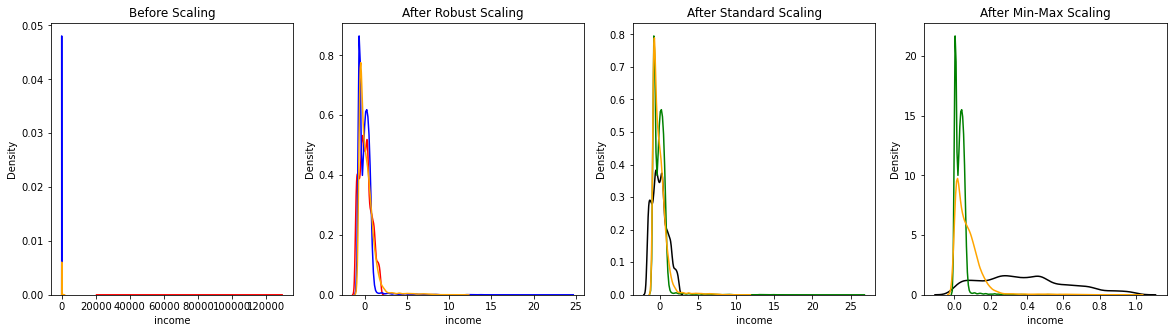

In [9]:
# Select colummns
columns = ['income', 'avg_spent','total_spent']

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(final_dataset[['income', 'avg_spent','total_spent']])
robust_df = pd.DataFrame(robust_df, columns = columns)
  
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(final_dataset[['income', 'avg_spent','total_spent']])
standard_df = pd.DataFrame(standard_df, columns = columns)
  
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(robust_df[['income', 'avg_spent','total_spent']])
minmax_df = pd.DataFrame(minmax_df, columns = columns)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
  
sns.kdeplot(final_dataset['income'], ax = ax1, color ='r')
sns.kdeplot(final_dataset['avg_spent'], ax = ax1, color ='b')
sns.kdeplot(final_dataset['total_spent'], ax = ax1, color ='orange')
ax2.set_title('After Robust Scaling')
  
sns.kdeplot(robust_df['income'], ax = ax2, color ='red')
sns.kdeplot(robust_df['avg_spent'], ax = ax2, color ='blue')
sns.kdeplot(robust_df['total_spent'], ax = ax2, color ='orange')
ax3.set_title('After Standard Scaling')
  
sns.kdeplot(standard_df['income'], ax = ax3, color ='black')
sns.kdeplot(standard_df['avg_spent'], ax = ax3, color ='g')
sns.kdeplot(standard_df['total_spent'], ax = ax3, color ='orange')
ax4.set_title('After Min-Max Scaling')
  
sns.kdeplot(minmax_df['income'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['avg_spent'], ax = ax4, color ='g')
sns.kdeplot(minmax_df['total_spent'], ax = ax4, color ='orange')
plt.show()

First to do the pre-processing we applied [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) because it removes outliers from the data. However, for the columns we are interested in, not all of them are organized in the same range because  ``time`` is in the range of *-1 to 1*, but ``income`` is in -2 and 2. What we want is that all the specified columns are in the same range, therefore, applying [**MinMaxScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) will achieve this since all the columns are in the range of *0 to 1*. 

In conclusion, first **RobustScaler** and then **MinMaxScaler** will be applied. Finally, coding of the categorical variables will be applied using **LabelEncoder**. And for this, a function that is in the file ``helpers.py`` will be performed. 

In [13]:
data_scaled = helpers.preprocessing_data(final_dataset)
data_scaled.head()

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
0,0,0.911111,1,0,2,0.047886,0.055432,1,0,4,0,0,0,0,5,0,5
1,0,0.777778,3,4,4,0.098881,0.048780,3,0,6,6,3,0,9,7,0,3
2,1,0.444444,2,3,4,0.035448,0.042129,1,2,5,0,0,3,7,5,4,3
3,1,0.255556,5,6,6,0.022388,0.026608,2,2,5,0,1,3,9,8,3,1
4,1,0.233333,1,2,3,0.009328,0.006652,0,2,4,0,0,3,6,3,4,1


In [14]:
data_scaled.shape

(14487, 17)

The following is a detailed description of the meaning of each of the labels that ``Label Encoder`` has created with the categorical variables:

<br>

##### Gender
* **F:** 0
* **M:** 1
* **O:** 2

<br>

##### age_range
* **2:** 0
* **3:** 1
* **5:** 2
* **10:** 3

<br>

##### channels
* **['email', 'mobile', 'social']:** 0
* **['web', 'email', 'mobile', 'social']:** 1
* **['web', 'email', 'mobile']:** 2
* **['web', 'email']:**  3
 
 <br>

##### difficulty
* **5:** 0
* **7:** 1
* **10:** 2
* **20:** 3

<br>

##### duration
* **5:** 0
* **7:** 1
* **10:** 2

<br>

##### offer type
* **bogo:** 0
* **discount:** 1


## Dimensionality Reduction
###### Roles and Buckets

In [15]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::523506571102:role/service-role/AmazonSageMaker-ExecutionRole-20210613T222655


In [16]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-523506571102



##### Define a PCA Model


* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.


In [17]:
# define location to store model artifacts
prefix = 'starbucks'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-523506571102/starbucks/


In [18]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS = data_scaled.shape[1] - 1

pca_starbucks = PCA(role=role,
             instance_count=1,
             instance_type='ml.p2.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The record_set function in the SageMaker PCA model converts a numpy array into a RecordSet format that is the required format for the training input data. This is a requirement for all of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.


In [19]:
# convert df to np array
train_data_np = data_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_starbucks.record_set(train_data_np)

### Train the model

In [43]:
%%time

# train the PCA mode on the formatted data
pca_starbucks.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-17 04:42:12 Starting - Starting the training job...
2021-06-17 04:42:39 Starting - Launching requested ML instancesProfilerReport-1623904932: InProgress
......
2021-06-17 04:43:39 Starting - Preparing the instances for training...............
2021-06-17 04:46:10 Downloading - Downloading input data
2021-06-17 04:46:10 Training - Downloading the training image...
2021-06-17 04:46:40 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/17/2021 04:46:35 INFO 139800000956224] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[06/17/2021 04:46:35 INFO 139800000956224] Merging with provided configur

#### Accessing the PCA Model Attributes

In [44]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-06-17-04-42-12-744'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

starbucks/pca-2021-06-17-04-42-12-744/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

In [45]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[  8.429521  26.027431  26.81646   36.325542  49.304764  60.88973
  69.86713  117.247246 141.33946  176.21779  205.10966  210.07256
 232.26009  275.1433   312.74768  460.00626 ]
<NDArray 16 @cpu(0)>, 'v': 
[[ 3.18557839e-03 -7.81635791e-02  7.37826107e-03  1.40297518e-03
  -1.12440594e-01  9.88959193e-01 -2.08910443e-02  1.02859633e-02
  -8.66883621e-03  5.61253866e-03 -2.89129708e-02  2.43291054e-02
  -7.57212471e-03  2.10041888e-02  2.93655996e-03 -2.35308390e-02]
 [-8.78858939e-02 -9.89152968e-01 -6.20757565e-02  9.91216861e-03
  -2.15466525e-02 -7.78500810e-02 -1.01529974e-02 -4.63129254e-03
   2.67041917e-03 -2.45285942e-03  3.01984232e-02 -2.09360085e-02
   7.42787262e-03 -9.99702793e-03  1.75119052e-03  1.87980253e-02]
 [-2.28298791e-02  1.39766140e-02  9.04494673e-02  8.38360250e-01
  -9.33418646e-02  5.99262057e-05 -2.11296249e-02 -2.47032389e-01
  -1.42061897e-02  1.79974988e-01 -2.54638307e-02  5.52906953e-02
  -7.09493160e-02 -1.94553122e-01 -1.72387194e-02  3.722293

#### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

   **mean:** The mean that was subtracted from a component in order to center it.
   
   **v:** The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
   
   **s:** The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in v and s.

In [46]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

####  Data Variance

Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much data variance the components capture.

<br>

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 85% coverage.

*Note: The top principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.*


In [47]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  

# print a selection of s
print(s.iloc[start_idx:, :])

             0
11  210.072556
12  232.260086
13  275.143311
14  312.747681
15  460.006256


In [48]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components 
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [49]:
# test cell
n_top_components = 5 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80019265


In conclusion, **5** components were defined as they explain at least 80% of the total variance.

<br>

### Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling *N_COMPONENTS-1* to get the top, 1, component.


In [50]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

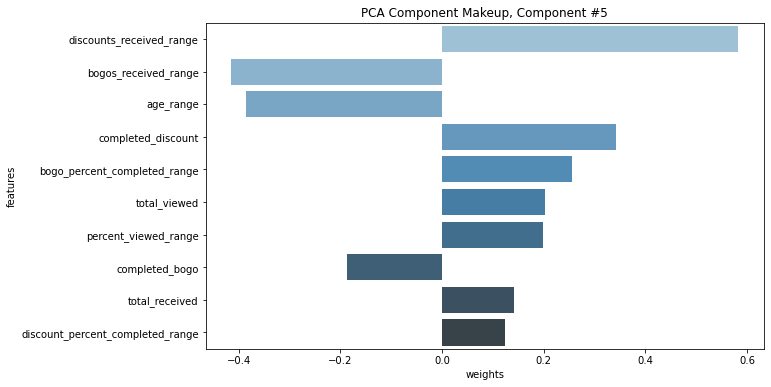

In [51]:
# display makeup of first component
num = 5
display_component(v, data_scaled.columns.values, component_num=num, n_weights=10)

###  Deploying the PCA Model

We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point.

In [52]:
%%time
# this takes a little while, around 8mins
pca_predictor = pca_starbucks.deploy(initial_instance_count=1, 
                              instance_type='ml.p2.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 253 ms, sys: 12.8 ms, total: 265 ms
Wall time: 7min 32s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [53]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [54]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.04098334163427353
      values: -0.33758804202079773
      values: -1.5152660608291626
      values: -0.3862875699996948
      values: -0.16776907444000244
      values: -0.5303946137428284
      values: 0.20309117436408997
      values: 0.17287135124206543
      values: 0.4031820297241211
      values: 0.3596435785293579
      values: -2.0268912315368652
      values: -3.3388209342956543
      values: 7.19050931930542
      values: -4.023331165313721
      values: -1.9289969205856323
      values: -2.620175838470459
    }
  }
}



In [55]:
def create_transformed_df(train_pca, data_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    data_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        data_transformed = data_transformed.append([list(components)])

    # index by county, just like counties_scaled
    data_transformed.index = data_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    data_transformed = data_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return data_transformed.iloc[:, ::-1]

In [56]:
# specify top n
top_n = 5

# call your function and create a new dataframe
data_transformed = create_transformed_df(train_pca, data_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5']
data_transformed.columns=PCA_list 

# print result
data_transformed.head()

,c_1,c_2,c_3,c_4,c_5
0,-2.620176,-1.928997,-4.023331,7.190509,-3.338821
1,4.298525,2.480468,2.814970,0.869880,-3.051544
2,-0.090560,-2.853034,-1.224657,0.493026,1.071919
3,5.288128,-3.513768,-0.159936,-1.837879,1.218396
4,-2.118860,-2.629998,-1.038443,0.802769,0.593156


In [57]:
# Save PCA dataset
data_transformed.to_csv('data/pca_scores.csv')

###   Delete the Endpoint!

Now that we've deployed the model and created our new, transformed training data, we no longer need the PCA endpoint.

In [58]:
# Delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Metrics 

#### Eblow method

Inertia measures how well a data set is clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance and summing these squares into a cluster.

A good model is one with low inertia AND a low number of clusters (K). However, this is a trade-off because as K increases, the inertia decreases.

To find the optimal K for a data set, use the Elbow method; find the point where the decrease in inertia begins to decrease.

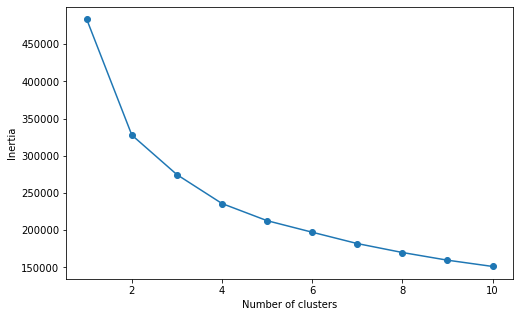

In [61]:
scores = []

for k in range(1,11):
    km = KMeans(n_clusters = k,random_state=1)
    km = km.fit(data_transformed)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Silhouette value 
The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [64]:
for i in range(2,17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(data_transformed)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(data_scaled,kmeans_labels, metric='euclidean').round(3)))

Silhouette score for 2 clusters k-means : 0.238 
Silhouette score for 3 clusters k-means : 0.18 
Silhouette score for 4 clusters k-means : 0.181 
Silhouette score for 5 clusters k-means : 0.17 
Silhouette score for 6 clusters k-means : 0.165 
Silhouette score for 7 clusters k-means : 0.159 
Silhouette score for 8 clusters k-means : 0.151 
Silhouette score for 9 clusters k-means : 0.143 
Silhouette score for 10 clusters k-means : 0.144 
Silhouette score for 11 clusters k-means : 0.144 
Silhouette score for 12 clusters k-means : 0.141 
Silhouette score for 13 clusters k-means : 0.134 
Silhouette score for 14 clusters k-means : 0.134 
Silhouette score for 15 clusters k-means : 0.137 
Silhouette score for 16 clusters k-means : 0.133 


#### Davies Bouldin

Average similarity measure of each cluster to its most similar cluster, where similarity is the ratio of distances within the cluster to distances between clusters. The minimum score is zero, and lower values indicate better clustering.


In [65]:
for i in range(2, 17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(data_transformed)
    print(f'Davies Bouldin Score {i}: {metrics.davies_bouldin_score(data_scaled,kmeans_labels).round(3)}')

Davies Bouldin Score 2: 1.655
Davies Bouldin Score 3: 1.756
Davies Bouldin Score 4: 1.88
Davies Bouldin Score 5: 1.813
Davies Bouldin Score 6: 1.748
Davies Bouldin Score 7: 1.779
Davies Bouldin Score 8: 1.872
Davies Bouldin Score 9: 1.91
Davies Bouldin Score 10: 1.833
Davies Bouldin Score 11: 1.844
Davies Bouldin Score 12: 1.893
Davies Bouldin Score 13: 1.843
Davies Bouldin Score 14: 1.874
Davies Bouldin Score 15: 1.86
Davies Bouldin Score 16: 1.851


In [66]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 3

kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.p2.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

#### Create formatted, k-means training data

Just as before, you should convert the data_transformed df into a numpy array and then into a RecordSet. This is the required format for passing training data into a KMeans model.

In [68]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = data_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [69]:
%%time

# train kmeans
kmeans.fit(kmeans_formatted_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-17 05:07:52 Starting - Starting the training job...
2021-06-17 05:08:15 Starting - Launching requested ML instancesProfilerReport-1623906472: InProgress
......
2021-06-17 05:09:15 Starting - Preparing the instances for training............
2021-06-17 05:11:15 Downloading - Downloading input data
2021-06-17 05:11:15 Training - Downloading the training image...
2021-06-17 05:11:46 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/17/2021 05:11:49 INFO 140685107672896] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]',

### Deploy the k-means model

In [70]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.p2.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 245 ms, sys: 17.4 ms, total: 262 ms
Wall time: 7min 32s


### Pass in the training data and assign predicted cluster labels

After deploying the model, you can pass in the k-means training data, as a numpy array, and get resultant, predicted cluster labels for each data point.

In [72]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

## Exploring the resultant clusters

The resulting predictions should give you information about the cluster that each data point belongs to.

In [73]:
# print cluster info for first data point
data_idx = 0

print('Person is: ', data_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

Person is:  0

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 2.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 8.859073638916016
    }
  }
}



### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points (counties) and visualize the distribution of points over each cluster.


In [74]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [75]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

1.0    7423
2.0    4314
0.0    2750
Name: 0, dtype: int64


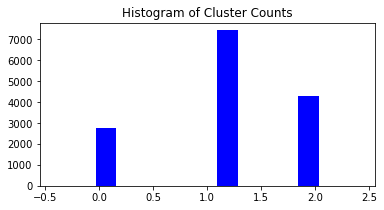

In [80]:
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 2.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

### Delete the Endpoint!

Now that you've deployed the k-means model and extracted the cluster labels for each data point, you no longer need the k-means endpoint.


In [ ]:
# Delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)


## Model Attributes & Explainability

Explaining the result of the modeling is an important step in making use of our analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, you can learn about a population and remark on some patterns you've found, based on the data.


In [81]:
# Download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2021-06-17-05-07-52-278'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [82]:
# Get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[-3.468093    3.236736    0.46956742 -0.12864326  0.25880012]
 [ 3.0401897   0.2254309  -0.13136438  0.05308683 -0.01628883]
 [-3.0993693  -2.1642327  -0.03697518 -0.01534642 -0.11657888]]
<NDArray 3x5 @cpu(0)>]


In [84]:
# Get all the centroids
cluster_centroids = pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns = data_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5
0,-3.468093,3.236736,0.469567,-0.128643,0.258800
1,3.040190,0.225431,-0.131364,0.053087,-0.016289
2,-3.099369,-2.164233,-0.036975,-0.015346,-0.116579


In [88]:
# Save clusteres
cluster_centroids.to_csv('data/cluster_centroids.csv')

### Visualizing Centroids in Component Space

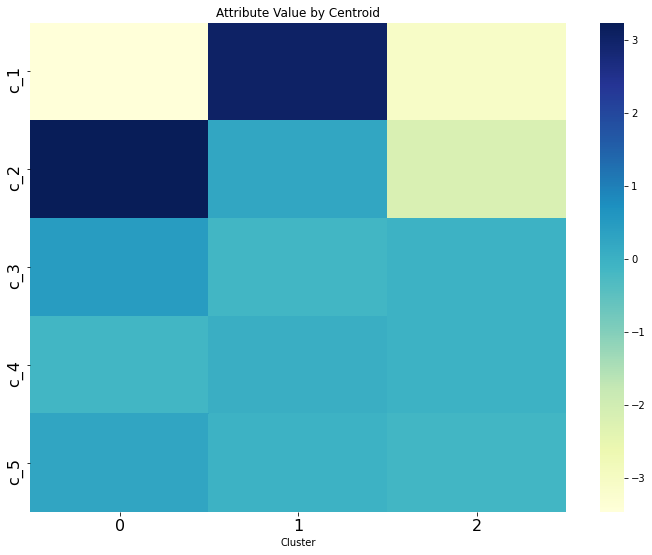

In [85]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

#### Natural Groupings

In [86]:
# add a 'labels' column to the dataframe
data_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_clients = data_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_clients.head(20)

,c_1,c_2,c_3,c_4,c_5,labels
14824,-0.453257,3.375813,-1.152848,1.742005,-1.537018,0
3343,-4.098703,3.540794,-1.833043,0.255713,2.407897,0
3344,-5.444523,3.321777,0.002448,-0.825086,3.101263,0
8629,0.422845,2.601662,2.196328,0.122770,2.644855,0
8628,-4.361684,3.546091,-1.042675,1.110242,0.033933,0
13827,-6.088354,3.536673,0.133250,0.554999,0.003783,0
8627,-3.549724,3.239955,0.309550,-1.442708,-0.424999,0
3349,-6.068601,3.506744,0.243597,-0.164961,-0.223712,0
8626,-0.182680,3.388781,-2.127401,1.417383,-0.057786,0
3355,-1.225404,3.392081,-2.161402,-4.789605,-1.248802,0


In [90]:
cluster_centroids.to_csv('data/kmeans_clusters.csv')

In [87]:
# Get all counties with label == 1
cluster = data_transformed[data_transformed['labels']==1]
cluster.head()

,c_1,c_2,c_3,c_4,c_5,labels
1,4.298525,2.480468,2.814970,0.869880,-3.051544,1
3,5.288128,-3.513768,-0.159936,-1.837879,1.218396,1
5,2.133414,2.696602,1.034133,-3.441165,-1.325144,1
7,2.587564,2.634673,0.706115,0.874080,2.463577,1
11,4.191177,-1.204991,-1.404837,1.565448,2.377470,1
